In [1]:
import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
# sns.set_context("poster")
# sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

from habits.cleaning import list_s3_files
from habits.processing import read_o2_data, classify_users, make_yX, print_info
from habits.modelling import make_stargazer, make_roc

%load_ext autoreload
%autoreload 2

# Effect of holidays on births

In [83]:
file = 'https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv'
df = pd.read_csv(file)

# Remove missing values
df = df.dropna(how='any')

# Remove outliers using sigma-clipping
quart = np.percentile(df.births, [25, 50, 75])
mu, sig = quart[1], 0.74 * (quart[2] - quart[0])
df = df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

print(df.shape)
df.head()

(14610, 5)


,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


Prepare data to have a single series with number of births per day of month with a datetime index.

In [37]:
from datetime import date

df.index = pd.to_datetime(df.year * 10_000 
               + df.month * 100 
               + df.day, format='%Y%m%d')

by_date = df.pivot_table('births', [df.index.month, df.index.day])
by_date.index = [date(2012, month, day) for month, day in by_date.index]

Make plot with custom formatting

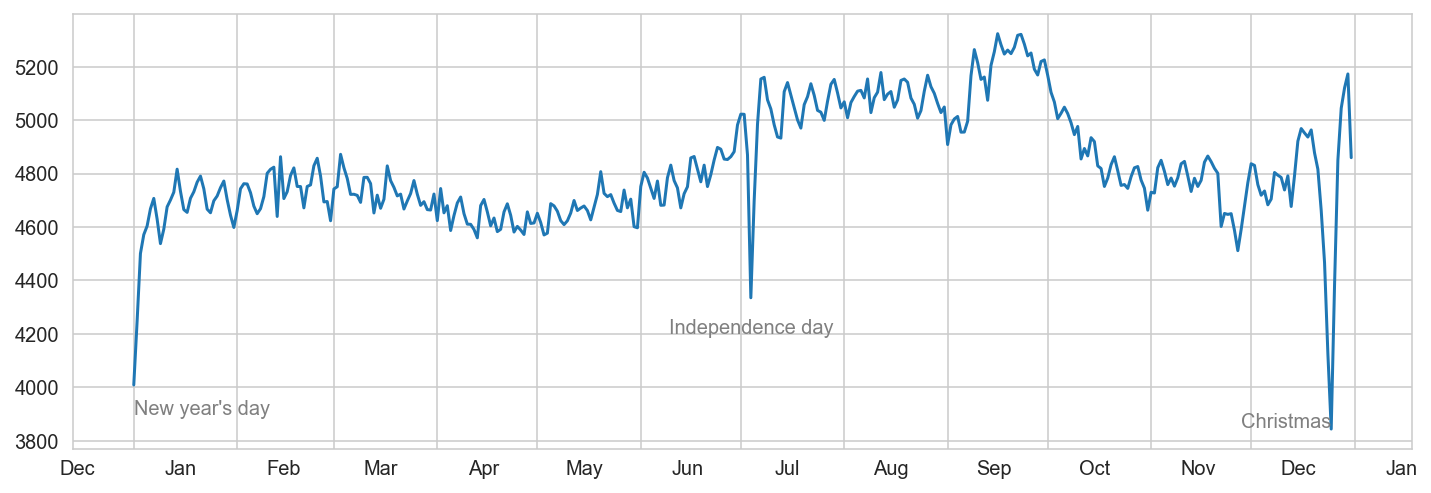

In [82]:
fig, ax = plt.subplots(figsize=(12, 4))
by_date.plot(ax=ax, legend=None);

# Format the x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'))

# Add custom labels
style = dict(size=10, color='gray')
ax.text('2012-1-1', 3900, "New year's day", ha='left', **style)
ax.text('2012-7-4', 4200, 'Independence day', ha='center', **style)
ax.text('2012-12-25', 3850, "Christmas", ha='right', **style);

# Efficient pandas with eval and query methods

In [19]:
rng = np.random.RandomState(2312)
df = pd.DataFrame(rng.rand(10**8, 3), columns=['a', 'b', 'c'])
df.head()

,a,b,c
0,0.624665,0.851950,0.026409
1,0.210052,0.682533,0.905552
2,0.606525,0.549488,0.455342
3,0.101478,0.719304,0.068105
4,0.547218,0.943891,0.527699


In [20]:
%timeit (df.a + df.b) / (df.c - 1)

1.84 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit df.eval('(a + b) / (c -1)')

2.12 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Datatime stuff from jvdp's handbook

In [34]:
file = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
data = pd.read_csv(file, skiprows=1, names=['date', 'total', 'east', 'west'],
                   parse_dates=True, index_col='date')

In [35]:
data.describe()

,total,east,west
count,67118.000000,67118.000000,67118.000000
mean,112.912527,51.559835,61.352692
std,144.160880,66.522811,89.768937
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,147.000000,69.000000,74.000000
max,1097.000000,698.000000,850.000000


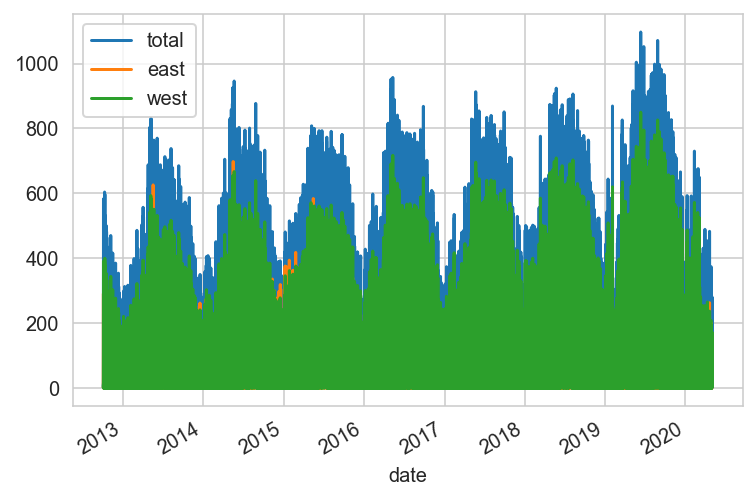

In [36]:
data.plot();

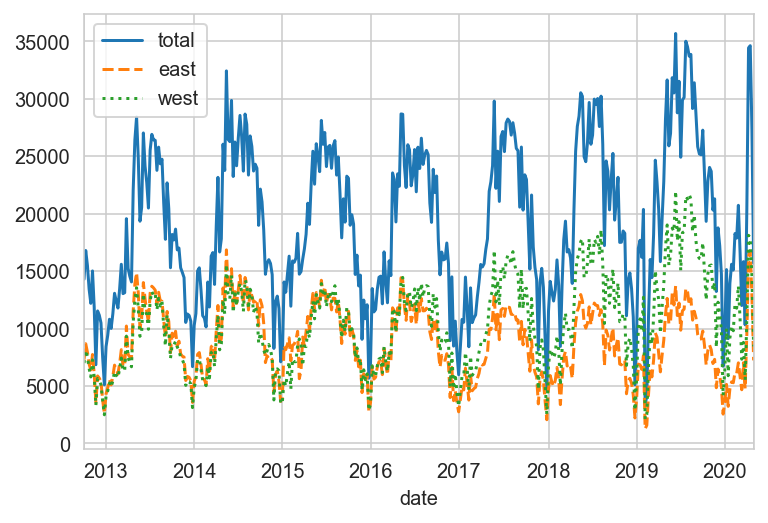

In [44]:
# Weekly aggregates

weekly = data.resample('W').sum()
weekly.plot(style=['-', '--', ':']);

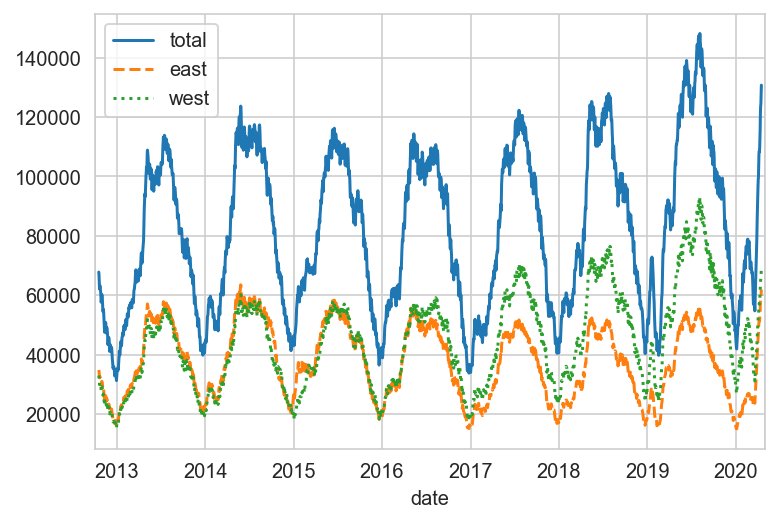

In [46]:
# Rolling window

daily = data.resample('D').sum()
daily.rolling(window=30, center=True).sum().plot(style=['-', '--', ':']);

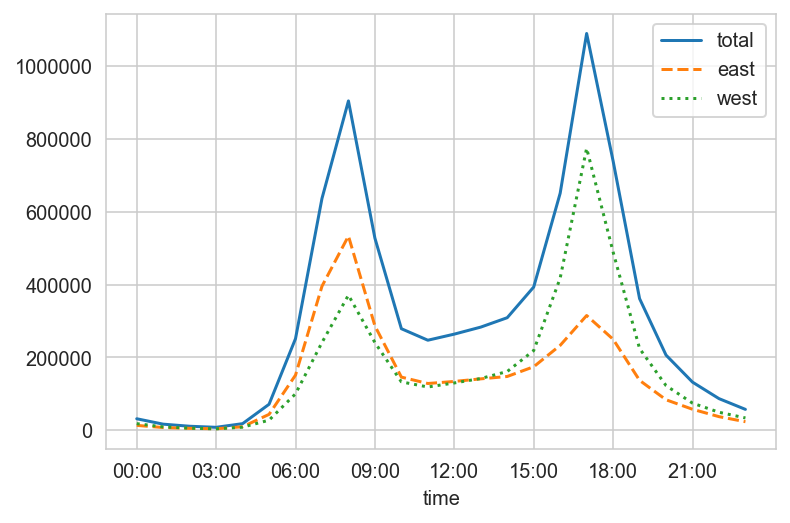

In [62]:
# By hour of day

by_time = data.groupby(data.index.time).sum()
hourly_ticks = 3 * 60 * 60 * np.arange(8)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':']);

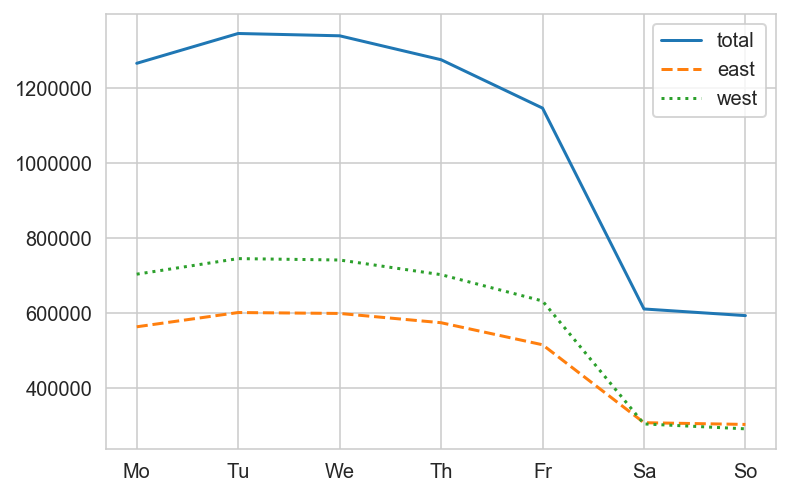

In [70]:
# By day of week

by_weekday = data.groupby(data.index.dayofweek).sum()
by_weekday.index = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'So']
by_weekday.plot(style=['-', '--', ':']);


In [95]:
mpl.get_configdir()

'/Users/fgu/.matplotlib'

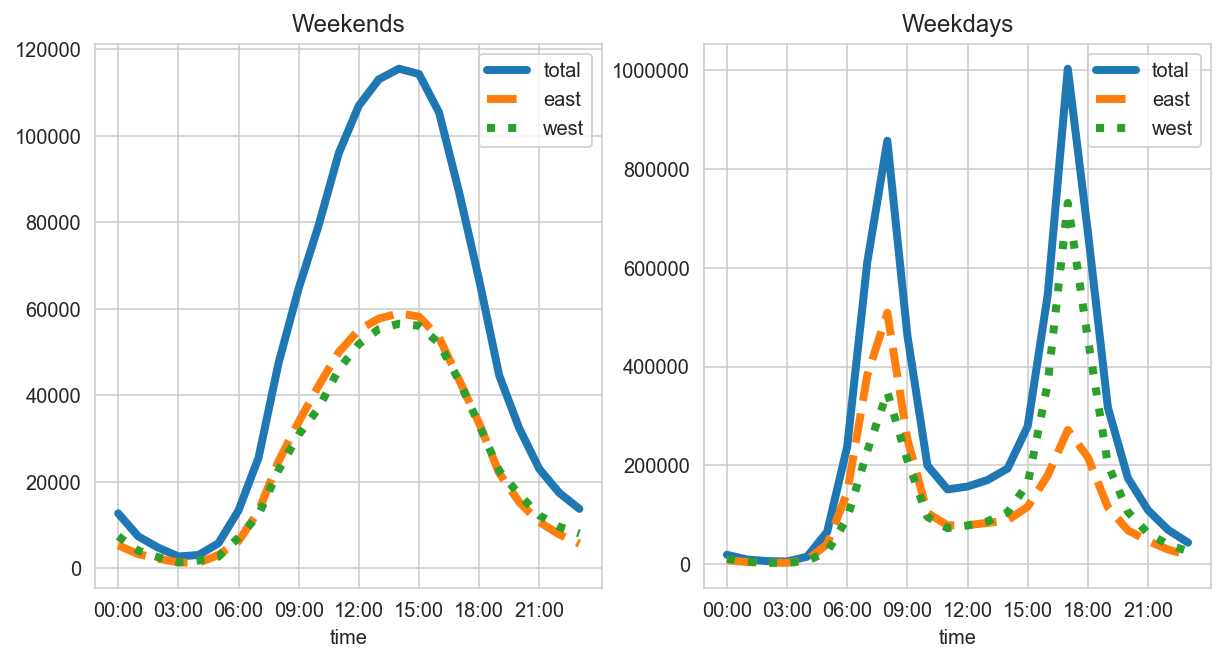

In [98]:
# Hourly by weekdays and weekends

wknd = np.where(data.index.dayofweek > 4, 'weekend', 'weekday')
hourly = data.groupby([wknd, data.index.time]).sum()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

hourly.loc['weekday'].plot(ax=ax1, title='Weekdays', xticks=hourly_ticks,
                           style=['-', '--', ':'])
hourly.loc['weekend'].plot(ax=ax0, title='Weekends', xticks=hourly_ticks,
                           style=['-', '--', ':']);

# Creating datetime indices

In [99]:
from dateutil.parser import parse

parse('3 Apr 2020').month
parse('3.4.2020').month
parse('3.4.2020', dayfirst=True).month

4

3

4

In [143]:
dates = pd.date_range(start='1/1/2000', freq='A-DEC', periods = 100)
values = np.random.randn(100)
ts = pd.Series(values, index=dates)
ts.head(10)

2000-12-31    0.843433
2001-12-31   -0.391251
2002-12-31    0.149087
2003-12-31    0.086131
2004-12-31   -2.308920
2005-12-31   -0.569420
2006-12-31    0.033575
2007-12-31    0.449340
2008-12-31    0.846790
2009-12-31    0.633025
Freq: A-DEC, dtype: float64

In [201]:
idx = pd.period_range('2018-1', '2019-12', freq='Q-DEC')
s = pd.Series(np.random.randn(len(idx)), index=idx)
s.asfreq('d', how='start').asfreq('Q')

2018Q1   -0.205351
2018Q2   -0.673207
2018Q3   -0.872625
2018Q4    2.045383
2019Q1   -0.696708
2019Q2   -0.798782
2019Q3   -1.904917
2019Q4   -0.436799
Freq: Q-DEC, dtype: float64

In [207]:
idx = pd.date_range('2000', periods=100)
s = pd.Series(np.random.randn(len(idx)), index=idx)
s.resample('M', kind='period').mean()

2000-01    0.014726
2000-02    0.056242
2000-03   -0.016878
2000-04   -0.690987
Freq: M, dtype: float64

In [249]:
idx = pd.date_range('2000', freq='H', periods=100)
s = pd.Series(np.random.randn(len(idx)), index=idx)
s.resample('d').ohlc()

,open,high,low,close
2000-01-01,-1.945039,2.231004,-2.751270,0.272018
2000-01-02,0.335163,2.173964,-0.895301,0.995886
2000-01-03,0.771501,1.399791,-2.465960,-0.030100
2000-01-04,1.765987,1.765987,-1.698415,-0.056522
2000-01-05,0.215849,1.192958,0.215849,0.786069


In [259]:
s.resample('min').asfreq().ffill()

2000-01-01 00:00:00   -1.945039
2000-01-01 00:01:00   -1.945039
2000-01-01 00:02:00   -1.945039
2000-01-01 00:03:00   -1.945039
2000-01-01 00:04:00   -1.945039
                         ...   
2000-01-05 02:56:00    1.192958
2000-01-05 02:57:00    1.192958
2000-01-05 02:58:00    1.192958
2000-01-05 02:59:00    1.192958
2000-01-05 03:00:00    0.786069
Freq: T, Length: 5941, dtype: float64

In [254]:
data = df.reset_index(level=0).head(100).sort_index()[['amount']]
data

,amount
transaction_date,
2012-08-29,12.00
2012-08-30,13.50
2012-08-30,7.44
2012-08-30,7.44
2012-08-30,13.50
...,...
2012-12-27,135.00
2012-12-27,3.60
2012-12-27,8.50


# IPython / notebook shortcuts 

In [24]:
clean_nb = !ls *2*
clean_nb

['2.0-fgu-clean-and-split-data.ipynb']

In [2]:
%%timeit
a = range(1000)

174 ns ± 4.23 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [3]:
%%writefile pythoncode.py

import numpy
def append_if_not_exists(arr, x):
    if x not in arr:
        arr.append(x)

def some_useless_slow_function():
    arr = list()
    for i in range(10000):
        x = numpy.random.randint(0, 10000)
        append_if_not_exists(arr, x)

Writing pythoncode.py


In [4]:
%pycat pythoncode.py


import numpy
def append_if_not_exists(arr, x):
    if x not in arr:
        arr.append(x)

def some_useless_slow_function():
    arr = list()
    for i in range(10000):
        x = numpy.random.randint(0, 10000)
        append_if_not_exists(arr, x)


In [1]:
# %magic -brief

I can transfer variables with any content from one notebook to the next (useful if you run a number of notebooks in sequence, for instance, and the ouput of one serves as the input of another).

In [5]:
var_to_pass_on = dfu.head()
%store var_to_pass_on

Stored 'var_to_pass_on' (DataFrame)


In [8]:
# I can pass on variables from one notebook (3.0-fgu) to another
%store -r var_to_pass_on
var_to_pass_on

,user_id,year_of_birth,user_registration_date,salary_range,postcode,gender,soa_lower,soa_middle,user_uid
0,3706,1967-01-01,2012-09-30,NaN,XXXX 0,M,NaN,NaN,3706-0
1,1078,1964-01-01,2011-11-29,20K to 30K,M25 9,M,E01005038,E02001043,1078-0
2,232,1965-01-01,2010-09-09,30K to 40K,CM4 0,M,E01021551,E02004495,232-0
3,6133,1968-01-01,2012-10-21,10K to 20K,SK12 1,M,E01018665,E02003854,6133-0
4,7993,1961-01-01,2012-10-29,20K to 30K,LS17 8,M,E01011556,E02002344,7993-0


In [6]:
!conda list | grep pandas


pandas                    1.0.1            py37h6c726b0_0  
pandas-flavor             0.2.0                      py_0    conda-forge


### Using R and Python together

In [7]:
# %conda install -c conda-forge rpy2
# %conda install tzlocal
# %conda install simplegeneric

In [1]:
import rpy2


In [21]:
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()


In [8]:
%reload_ext rpy2.ipython

In [10]:
%R require(ggplot2)

R[write to console]: Loading required package: ggplot2



array([0], dtype=int32)

In [11]:
import pandas as pd
df = pd.DataFrame({
        'Letter': ['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c'],
        'X': [4, 3, 5, 2, 1, 7, 7, 5, 9],
        'Y': [0, 4, 3, 6, 7, 10, 11, 9, 13],
        'Z': [1, 2, 3, 1, 2, 3, 1, 2, 3]
    })

In [12]:
%%R -i df
ggplot(data = df) + geom_point(aes(x = X, y= Y, color = Letter, size = Z))

R[write to console]: Error in ggplot(data = df) : could not find function "ggplot"
Calls: <Anonymous> -> <Anonymous> -> withVisible

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘ggplot’

R[write to console]: 2: 
R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘ggplot2’




Error in ggplot(data = df) : could not find function "ggplot"
Calls: <Anonymous> -> <Anonymous> -> withVisible


### Printing virtually anything

In [3]:
happy_squirrels = !ls /Users/fgu/Library/Mobile\ Documents/com~apple~CloudDocs/fab/photos/squirrels/

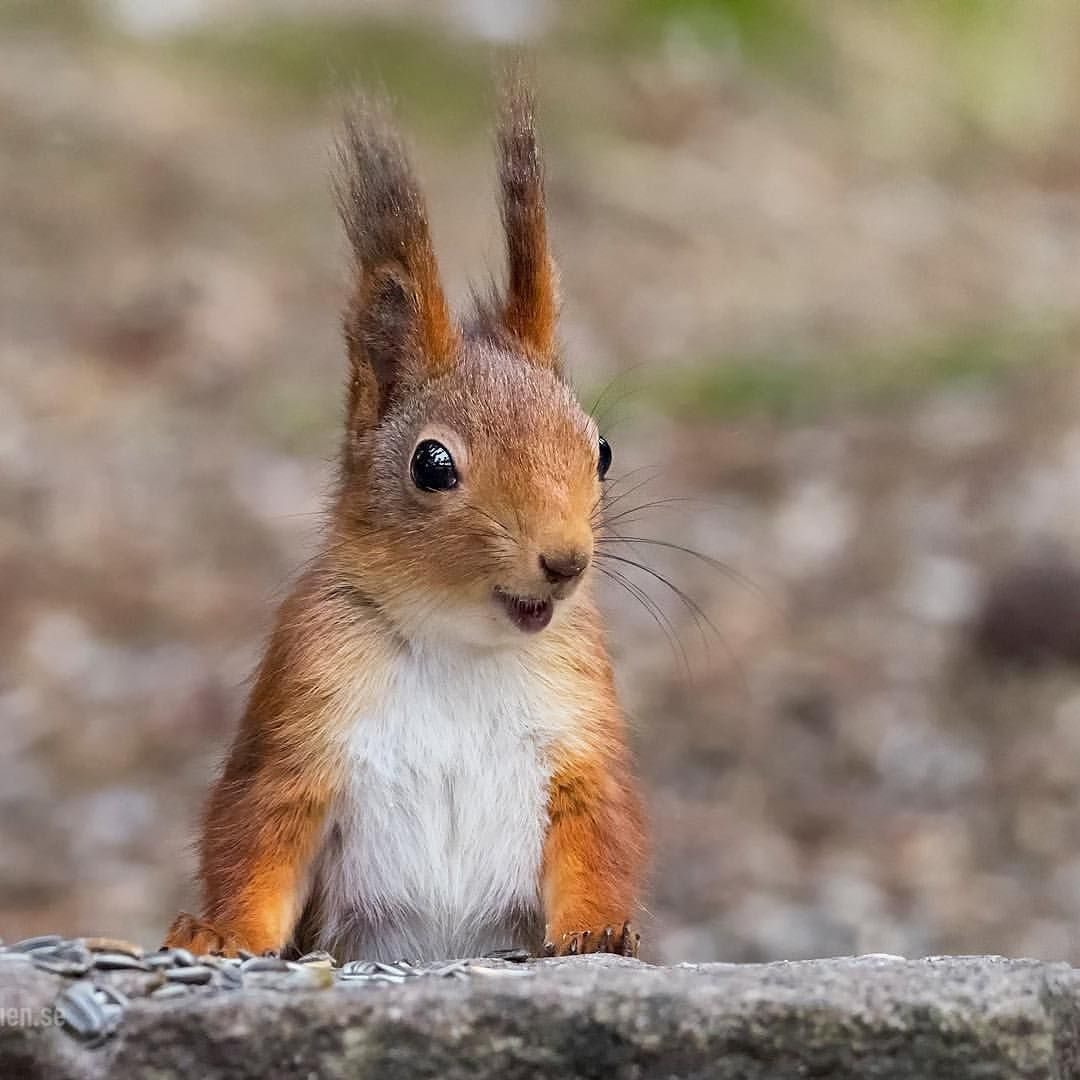

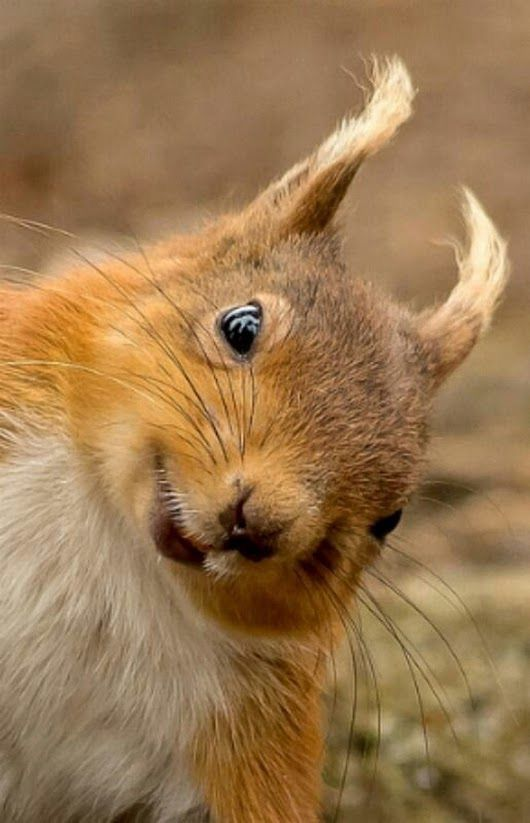

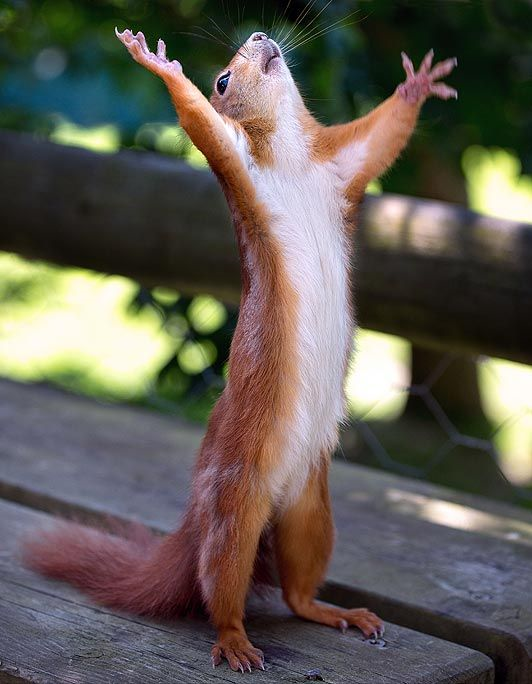

In [4]:
from IPython.display import display, Image
for s in happy_squirrels:
    display(Image('/Users/fgu/Library/Mobile Documents/com~apple~CloudDocs/fab/photos/squirrels/' + s, width=100))


### Write code to and load code from file

In [2]:
%%writefile test.py

print('Hello')

Overwriting test.py


In [3]:
%pycat test.py


print('Hello')


# Data from wide to long and back

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/macrodata.csv')
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [33]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name = 'date')
columns = pd.Index(['realgdp', 'cpi', 'unemp', 'infl'], name='item')
df = data.reindex(columns=columns)
df.index = periods.to_timestamp('D', 'End')
dfl = df.stack().reset_index().rename(columns={0:'value'})
dfl

,date,item,value
0,1959-03-31 23:59:59.999999999,realgdp,2710.349
1,1959-03-31 23:59:59.999999999,cpi,28.980
2,1959-03-31 23:59:59.999999999,unemp,5.800
3,1959-03-31 23:59:59.999999999,infl,0.000
4,1959-06-30 23:59:59.999999999,realgdp,2778.801
...,...,...,...
807,2009-06-30 23:59:59.999999999,infl,3.370
808,2009-09-30 23:59:59.999999999,realgdp,12990.341
809,2009-09-30 23:59:59.999999999,cpi,216.385
810,2009-09-30 23:59:59.999999999,unemp,9.600


In [46]:
# Use unstack to get wide data

dfl.set_index(['date', 'item']).unstack()

value                       
item                               cpi  infl    realgdp unemp
date                                                         
1959-03-31 23:59:59.999999999   28.980  0.00   2710.349   5.8
1959-06-30 23:59:59.999999999   29.150  2.34   2778.801   5.1
1959-09-30 23:59:59.999999999   29.350  2.74   2775.488   5.3
1959-12-31 23:59:59.999999999   29.370  0.27   2785.204   5.6
1960-03-31 23:59:59.999999999   29.540  2.31   2847.699   5.2
...                                ...   ...        ...   ...
2008-09-30 23:59:59.999999999  216.889 -3.16  13324.600   6.0
2008-12-31 23:59:59.999999999  212.174 -8.79  13141.920   6.9
2009-03-31 23:59:59.999999999  212.671  0.94  12925.410   8.1
2009-06-30 23:59:59.999999999  214.469  3.37  12901.504   9.2
2009-09-30 23:59:59.999999999  216.385  3.56  12990.341   9.6

[203 rows x 4 columns]

In [47]:
# Use pivot to get wide data

dfl.pivot('date', 'item', 'value')

item,cpi,infl,realgdp,unemp
date,,,,
1959-03-31 23:59:59.999999999,28.980,0.00,2710.349,5.8
1959-06-30 23:59:59.999999999,29.150,2.34,2778.801,5.1
1959-09-30 23:59:59.999999999,29.350,2.74,2775.488,5.3
1959-12-31 23:59:59.999999999,29.370,0.27,2785.204,5.6
1960-03-31 23:59:59.999999999,29.540,2.31,2847.699,5.2
...,...,...,...,...
2008-09-30 23:59:59.999999999,216.889,-3.16,13324.600,6.0
2008-12-31 23:59:59.999999999,212.174,-8.79,13141.920,6.9
2009-03-31 23:59:59.999999999,212.671,0.94,12925.410,8.1


## HDF5 

Following [this](https://www.youtube.com/watch?v=wZEFoVUu8h0) video.

In [39]:
import h5py
import numpy as np

Create a HDF5 file object, which works kind of like a Python dictionary.

In [40]:
f = h5py.File('demo.hdf5')

In [41]:
data = np.arange(10)
data

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
f['array'] = data

In [43]:
dset = f['array']

In [44]:
dset

<HDF5 dataset "array": shape (10,), type "<i8">

In [45]:
dset[:]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [46]:
dset[[1, 2, 5]]

array([1, 2, 5])

In [47]:
dset.attrs

<Attributes of HDF5 object at 4425393432>

Atributes again have dictionarry structure, so can add attribute like so:

In [48]:
dset.attrs['sampling frequency'] = 'Every other week between 1 Jan 2001 and 7 Feb 2010'
dset.attrs['PI'] = 'Fabian'

In [49]:
list(dset.attrs.items())
for i in dset.attrs.items():
    print(i)

('sampling frequency', 'Every other week between 1 Jan 2001 and 7 Feb 2010')
('PI', 'Fabian')


In [50]:
f.close()

In [51]:
f = h5py.File('demo.hdf5')

In [52]:
list(f.keys())

['array']

In [53]:
dset = f['array']

hdf5 files are organised in a hierarchy - that's what "h" stands for.

In [54]:
dset.name

'/array'

In [55]:
root = f['/']

In [56]:
list(root.keys())

['array']

In [57]:
f['dataset'] = data

In [58]:
f['full/dataset'] = data

In [59]:
grp = f['full']

In [60]:
'dataset' in grp

True

In [61]:
list(grp.keys())

['dataset']

In [64]:
dset2 = f.create_dataset('/full/bigger', (10000, 1000, 1000, 1000), dtype='f', compression='gzip')

In [67]:
list(f['full'].keys())

['bigger', 'dataset']

# Misc. 

In [ ]:
# Slicing with hierarchical index

idx = pd.IndexSlice
df.loc[idx[:, "2014"], :]

In [141]:
# Calculate z score manually

from scipy import stats

s = np.arange(5)

std = np.std(s)
mean = np.mean(s)

manual_z = (s - mean) / std
scipy_z = stats.zscore(s)

manual_z == scipy_z

array([ True,  True,  True,  True,  True])

In [8]:
np.arange(32).reshape((4, 8))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31]])

In [29]:
import random

print("one") if random.randint(0, 1) else print("zero")

zero


In [93]:
# Simulating a single random walk

ndraws = 1000
draws = np.random.randint(0, 2, ndraws)
steps = np.where(draws > 0, 1, -1)
walk = steps.cumsum()

# Find how long it took to make 10 steps in either direction

idx = (np.abs(walk) >= 10).argmax()
print("It took {} steps to get to {}".format(idx, walk[idx]))

It took 57 steps to get to -10


In [121]:
# Simulating many random walks together

nwalks = 5000
ndraws = 1000
draws = np.random.randint(0, 2, size=(nwalks, ndraws))
steps = np.where(draws > 0, 1, -1)
walk = steps.cumsum(axis=1)

# Find number of walks that cross 30 and the average crossing time

hit30 = (np.abs(walk) >= 30).any(1)
crossing_times = (np.abs(walk[hit30]) >= 30).argmax(1)

print(
    "{} walks cross 30, taking {} steps on average.".format(
        hit30.sum(), crossing_times.mean()
    )
)

3385 walks cross 30, taking 498.33353028064994 steps on average.


# Grouping

In [2]:
df = pd.DataFrame({'key1': ['a', 'b', 'c', 'd', 'e'],
                   'key2': ['one', 'two', 'one', 'two', 'one'],
                   'data1': np.random.randn(5),
                   'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.722346,1.350070
1,b,two,-0.864278,0.652911
2,c,one,0.875035,0.838726
3,d,two,1.420677,-0.464896
4,e,one,-0.789309,0.148121


In [3]:
# Loop over groups

for group, data in df.groupby('key1'):
    print(group)
    print(data)

a
  key1 key2     data1    data2
0    a  one -0.722346  1.35007
b
  key1 key2     data1     data2
1    b  two -0.864278  0.652911
c
  key1 key2     data1     data2
2    c  one  0.875035  0.838726
d
  key1 key2     data1     data2
3    d  two  1.420677 -0.464896
e
  key1 key2     data1     data2
4    e  one -0.789309  0.148121


In [9]:
# Save groups in dict 

pieces = dict(list(df.groupby('key1')))
pieces['a']

,key1,key2,data1,data2
0,a,one,-0.722346,1.35007


In [13]:
grouped = df.groupby(df.dtypes, axis=1)
for dtype, data in grouped:
    print(dtype)
    print(data)

float64
      data1     data2
0 -0.722346  1.350070
1 -0.864278  0.652911
2  0.875035  0.838726
3  1.420677 -0.464896
4 -0.789309  0.148121
object
  key1 key2
0    a  one
1    b  two
2    c  one
3    d  two
4    e  one


# Solution to my common indexing problem (index with shorter boolean series)

Problem: I want to index my df based on a boolean series that is shorter than the length of the df. E.g. I have a subset of users that fulfill a condition and want to keep these only.

In [72]:
# Data

data = o2.sample(frac=0.05)

In [84]:
# The boolean array of users who spent more than £100

high_spender = data.groupby("user_id").amount.sum() > 350

In [1]:
# Use transform to get boolean series of same length as original df so I can use indexing

In [85]:
# Use df.drop()

todrop = high_spender[~high_spender].index.values
data.drop(todrop, level=0).sort_index()

transaction_id  \
user_id transaction_date                   
20912   2013-12-18              12152457   
        2014-04-17              17466459   
        2015-01-19              54324542   
        2015-03-24              80422755   
        2015-09-23              96952964   
        2016-04-25             134730196   
        2016-05-17             138708140   
        2016-08-17             154735556   
        2016-10-07             163699913   
160992  2014-09-29              38730708   
        2015-01-19              54406685   
        2015-01-19              54406686   

                                                   transaction_description  \
user_id transaction_date                                                     
20912   2013-12-18              card purchase o2 uk ref xxx xxxxxx0000 bcc   
        2014-04-17                         direct debit o2 gedxxxxx154 ddr   
        2015-01-19                         direct debit o2 gedxxxx9154 ddr   
        2015-03-24                         direct debit o2 gedxxxx9097 ddr   
        2015-09-23                      counter credit <mdbremoved> o2 bgc   
        2016-04-25                         direct debit o2 gedxxxx9097 ddr   
        2016-05-17                         direct debit o2 gedxxxx1717 ddr   
        2016-08-17                         direct debit o2 gedxxxx9154 ddr   
        2016-10-07        counter credit <mdbremoved> o2/ <mdbremoved> bgc   
160992  2014-09-29                                           o2 uk cd 9531   
        2015-01-19                                           o2 uk cd 9531   
        2015-01-19                                           o2 uk cd 9531   

                              amount auto_tag merchant_name account_type  
user_id transaction_date                                                  
20912   2013-12-18         11.990000   mobile            o2      current  
        2014-04-17         44.160000   mobile            o2      current  
        2015-01-19         38.380001   mobile            o2      current  
        2015-03-24         34.799999   mobile            o2      current  
        2015-09-23         54.500000   mobile            o2      current  
        2016-04-25         40.990002   mobile            o2      current  
        2016-05-17         30.000000   mobile            o2      current  
        2016-08-17         34.270000   mobile            o2      current  
        2016-10-07         68.059998   mobile            o2      current  
160992  2014-09-29         25.000000   mobile            o2      current  
        2015-01-19        175.000000   mobile            o2      current  
        2015-01-19        202.539993   mobile            o2      current

In [110]:
high_spender

user_id
8         False
659       False
1078      False
1146      False
2324      False
          ...  
420102    False
421678    False
423912    False
424865    False
425830    False
Name: amount, Length: 210, dtype: bool

In [118]:
# Use isin()

hs = high_spender[high_spender].index.values
mask = data.index.isin(hs, level=0)
data[mask].sort_index()

transaction_id  \
user_id transaction_date                   
20912   2013-12-18              12152457   
        2014-04-17              17466459   
        2015-01-19              54324542   
        2015-03-24              80422755   
        2015-09-23              96952964   
        2016-04-25             134730196   
        2016-05-17             138708140   
        2016-08-17             154735556   
        2016-10-07             163699913   
160992  2014-09-29              38730708   
        2015-01-19              54406685   
        2015-01-19              54406686   

                                                   transaction_description  \
user_id transaction_date                                                     
20912   2013-12-18              card purchase o2 uk ref xxx xxxxxx0000 bcc   
        2014-04-17                         direct debit o2 gedxxxxx154 ddr   
        2015-01-19                         direct debit o2 gedxxxx9154 ddr   
        2015-03-24                         direct debit o2 gedxxxx9097 ddr   
        2015-09-23                      counter credit <mdbremoved> o2 bgc   
        2016-04-25                         direct debit o2 gedxxxx9097 ddr   
        2016-05-17                         direct debit o2 gedxxxx1717 ddr   
        2016-08-17                         direct debit o2 gedxxxx9154 ddr   
        2016-10-07        counter credit <mdbremoved> o2/ <mdbremoved> bgc   
160992  2014-09-29                                           o2 uk cd 9531   
        2015-01-19                                           o2 uk cd 9531   
        2015-01-19                                           o2 uk cd 9531   

                              amount auto_tag merchant_name account_type  
user_id transaction_date                                                  
20912   2013-12-18         11.990000   mobile            o2      current  
        2014-04-17         44.160000   mobile            o2      current  
        2015-01-19         38.380001   mobile            o2      current  
        2015-03-24         34.799999   mobile            o2      current  
        2015-09-23         54.500000   mobile            o2      current  
        2016-04-25         40.990002   mobile            o2      current  
        2016-05-17         30.000000   mobile            o2      current  
        2016-08-17         34.270000   mobile            o2      current  
        2016-10-07         68.059998   mobile            o2      current  
160992  2014-09-29         25.000000   mobile            o2      current  
        2015-01-19        175.000000   mobile            o2      current  
        2015-01-19        202.539993   mobile            o2      current